In [1]:
import re
import sys

import pandas as pd
import numpy as np
import xgboost as xgb

from xgboost import cv
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import KFold

from typing import Tuple, Dict, List
from time import time

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('display.max_columns', None)

random_state = 1973

In [2]:
df_train = pd.read_hdf("./input/train_airline_delay.h5")
df_test = pd.read_csv("./input/test_airline_delay.csv")

In [3]:
# histograms of the variables
# df_train.hist(figsize=(15,12), bins=30)
# plt.show()

In [4]:
df_train["scheduled_elapsed_time"].fillna(value=0, inplace=True)
if "origin_cat" not in df_train.columns:
    df_train["origin_cat"] = df_train["origin"].factorize()[0]
    df_train["destination_cat"] = df_train["destination"].factorize()[0]
    
df_test["scheduled_elapsed_time"].fillna(value=0, inplace=True)
if "origin_cat" not in df_test.columns:
    df_test["origin_cat"] = df_test["origin"].factorize()[0]
    df_test["destination_cat"] = df_test["destination"].factorize()[0]

In [6]:
df_filtered = df_train.copy()
df_filtered.head()

,year,month,actual_departure_time,day_of_month,day_of_week,scheduled_departure_time,actual_arrival_time,scheduled_arrival_time,air_time,arrival_delay,depature_delay,carrier_id,flight_number,tail_number,actual_elapsed_time,scheduled_elapsed_time,origin,destination,distance,is_cancelled,cancellation_code,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,is_diverted,target_delay,origin_cat,destination_cat
0,0,1,943.0,17,2,947.0,1028.0,1037.0,33.0,-9.0,-4.0,13,4780,3022,45.0,50.0,MLI,ORD,139,False,0,0.0,0.0,0.0,0.0,0.0,False,0.0,0,0
1,2,6,905.0,26,4,822.0,1026.0,932.0,117.0,54.0,43.0,7,246,1993,141.0,130.0,SAT,DEN,794,False,0,43.0,0.0,11.0,0.0,0.0,False,54.0,1,1
2,1,12,1255.0,28,5,1255.0,1342.0,1344.0,25.0,-2.0,0.0,13,4867,4955,47.0,49.0,LAX,SBA,89,False,0,0.0,0.0,0.0,0.0,0.0,False,0.0,2,2
3,1,7,2028.0,2,1,1855.0,2136.0,1945.0,33.0,111.0,93.0,15,1505,3734,68.0,50.0,DFW,AUS,190,False,0,0.0,17.0,18.0,0.0,76.0,False,111.0,3,3
4,2,1,1358.0,7,1,1355.0,1437.0,1455.0,85.0,-18.0,3.0,1,5541,5727,99.0,120.0,SLC,LAX,590,False,0,NaN,NaN,NaN,NaN,NaN,False,0.0,4,4


In [7]:
df_test.head()

,id,year,month,day_of_month,day_of_week,scheduled_departure_time,scheduled_arrival_time,carrier_id,flight_number,tail_number,scheduled_elapsed_time,origin,destination,distance,target_delay,origin_cat,destination_cat
0,0,1,1,17,3,1210.0,1510.0,17,152,4311,180.0,PBI,BOS,1197,NaN,0,0
1,1,0,2,22,3,1325.0,1613.0,15,1639,3909,168.0,MIA,JFK,1090,NaN,1,1
2,2,0,10,2,1,1720.0,1850.0,13,6140,3089,90.0,PIT,LGA,335,NaN,2,2
3,3,0,4,24,1,800.0,1141.0,8,5026,2466,221.0,BOS,RSW,1249,NaN,3,3
4,4,2,1,21,1,1625.0,1840.0,1,1706,790,75.0,LAX,PHX,370,NaN,4,4


## Features

In [8]:
feats = [
 'year',
 'month',
 'day_of_month',
 'day_of_week',
 'scheduled_departure_time',
 'scheduled_arrival_time',
 'carrier_id',
 'flight_number',
 'tail_number',
 'scheduled_elapsed_time',
 'distance',
 'origin_cat',
 'destination_cat']

In [9]:
all_feats = feats +  ['target_delay']

## X, y

In [10]:
X = df_filtered[feats].copy()
y = df_filtered["target_delay"].copy()

X_val = df_test[feats]

In [11]:
# histograms of the variables
# X_train.hist(figsize=(15,12), bins=30)
# plt.show()

In [12]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(X)
X_transf = scaler.transform(X)

y_values = y.values.copy()

### Metryka rmsle

In [13]:
def rmsle(actual, predicted):
    """
    Computes the root mean squared log error.

    This function computes the root mean squared log error between two lists
    of numbers.

    Parameters
    ----------
    actual : list of numbers, numpy array
             The ground truth value
    predicted : same type as actual
                The predicted value

    Returns
    -------
    score : double
            The root mean squared log error between actual and predicted

    """
    return np.sqrt(msle(actual, predicted))

## Basic model

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_transf, y_values, test_size=0.2, random_state=random_state)

In [15]:
from sklearn.dummy import DummyRegressor

model = DummyRegressor(strategy='median')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmsle(y_test, y_pred)

2.3494757237053983

In [16]:
# xgboost

In [17]:
model = xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.3, tree_method='gpu_hist', random_state=random_state)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [18]:
y_pred[y_pred < 0 ] = 0

In [19]:
rmsle(y_test, y_pred)

2.639571523964277

## Nowy dataset - train

In [21]:
train = pd.merge(X, y, left_index=True, right_index=True)
train.head()

,year,month,day_of_month,day_of_week,scheduled_departure_time,scheduled_arrival_time,carrier_id,flight_number,tail_number,scheduled_elapsed_time,distance,origin_cat,destination_cat,target_delay
0,0,1,17,2,947.0,1037.0,13,4780,3022,50.0,139,0,0,0.0
1,2,6,26,4,822.0,932.0,7,246,1993,130.0,794,1,1,54.0
2,1,12,28,5,1255.0,1344.0,13,4867,4955,49.0,89,2,2,0.0
3,1,7,2,1,1855.0,1945.0,15,1505,3734,50.0,190,3,3,111.0
4,2,1,7,1,1355.0,1455.0,1,5541,5727,120.0,590,4,4,0.0


In [22]:
train.select_dtypes(include=[np.number]).columns 

Index(['year', 'month', 'day_of_month', 'day_of_week',
       'scheduled_departure_time', 'scheduled_arrival_time', 'carrier_id',
       'flight_number', 'tail_number', 'scheduled_elapsed_time', 'distance',
       'origin_cat', 'destination_cat', 'target_delay'],
      dtype='object')

### Funkcje pomocnicze

In [21]:
def get_feats(df):
    feats = df.select_dtypes(include=[np.number]).columns 
    return feats[ feats != 'target_delay' ].values

def get_X(df):
    
    X_temp = df[ get_feats(df) ]
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_temp)
    X_train_transf = scaler.transform(X_temp)
    
    return X_train_transf

def get_y(df, target_var='target_delay'):
    return df[target_var].values

def get_models():
    return [
        ('dummy_mean', DummyRegressor(strategy='mean')),
        ('dummy_median', DummyRegressor(strategy='median')),
        ('xgb_initial', xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.3, tree_method='gpu_hist', random_state=random_state))
    ]

def run_cv(model, X, y, folds=5, target_log=False, cv_type=KFold, success_metric=rmsle):
    
    cv = cv_type(n_splits=folds, shuffle=False)
    
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if target_log:
            y_train = np.log(y_train + 1)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        if target_log:
            y_pred = np.exp(y_pred) - 1
            y_pred[y_pred < 0] = 0          #czasem może być wartość ujemna
        
        y_pred[y_pred < 0] = 0
        score = success_metric(y_test, y_pred)
        scores.append( score )
        
    return np.mean(scores), np.std(scores)


def plot_learning_curve(model, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), target_log=False):
    
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    if target_log:
        y = np.log(y + 1)
    
    def my_scorer(model, X, y):
        y_pred = model.predict(X)
       
        if target_log:
            y = np.exp(y) - 1
            y_pred = np.exp(y_pred)
            y_pred[ y_pred<0 ] = 0
        
        y_pred[ y_pred<0 ] = 0
        return rmsle(y, y_pred)

        
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=my_scorer)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt


def run(train, plot_lc=False, folds=5, ylim=(0,2), target_log=False):
    
    X, y  = get_X(train), get_y(train)

    for model_name, model in get_models():
        score_mean, score_std = run_cv(model, X, y, folds=folds, target_log=target_log)
        
        print("[{0}]: {1} +/-{2}".format(model_name, score_mean, score_std))
        sys.stdout.flush() #wypisujemy wynik natychmiast, bez buforowania

        if False == plot_lc: continue
        plt = plot_learning_curve(model, model_name, X, y, ylim=ylim, cv=folds, target_log=target_log)
        plt.show()

### get_feats

In [22]:
get_feats(train)

array(['year', 'month', 'day_of_month', 'day_of_week',
       'scheduled_departure_time', 'scheduled_arrival_time', 'carrier_id',
       'flight_number', 'tail_number', 'scheduled_elapsed_time',
       'distance', 'origin_cat', 'destination_cat'], dtype=object)

### get_X, get_y()

In [23]:
X = get_X(train)
X

array([[0.        , 0.        , 0.53333333, ..., 0.02585336, 0.        ,
        0.        ],
       [1.        , 0.45454545, 0.83333333, ..., 0.15814987, 0.00324675,
        0.00324675],
       [0.5       , 1.        , 0.9       , ..., 0.01575439, 0.00649351,
        0.00649351],
       ...,
       [1.        , 0.63636364, 0.46666667, ..., 0.02363159, 0.16558442,
        0.49675325],
       [0.        , 0.54545455, 0.73333333, ..., 0.0618057 , 0.22402597,
        0.11038961],
       [0.5       , 0.27272727, 0.4       , ..., 0.26095738, 0.07142857,
        0.04545455]])

In [24]:
y = get_y(train)
y

array([ 0., 54.,  0., ...,  0., 13.,  0.])

### get_models()

In [25]:
get_models()

[('dummy_mean', DummyRegressor()),
 ('dummy_median', DummyRegressor(strategy='median')),
 ('xgb_initial',
  XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, gamma=None,
               gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.3, max_bin=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, predictor=None, random_state=1973,
               reg_alpha=None, reg_lambda=None, ...))]

### run_cv bez log

In [26]:
model

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=1973,
             reg_alpha=0, reg_lambda=1, ...)

In [27]:
run_cv(model, X, y, folds=5, target_log=False, cv_type=KFold, success_metric=rmsle)

(2.641025649402719, 0.006767660761945188)

### run_cv z log

In [28]:
run_cv(model, X, y, folds=5, target_log=True, cv_type=KFold, success_metric=rmsle)

(1.5952884247903867, 0.0030329615726165543)

### run() bez log

[dummy_mean]: 3.683134576330018 +/-0.0024932553180097242


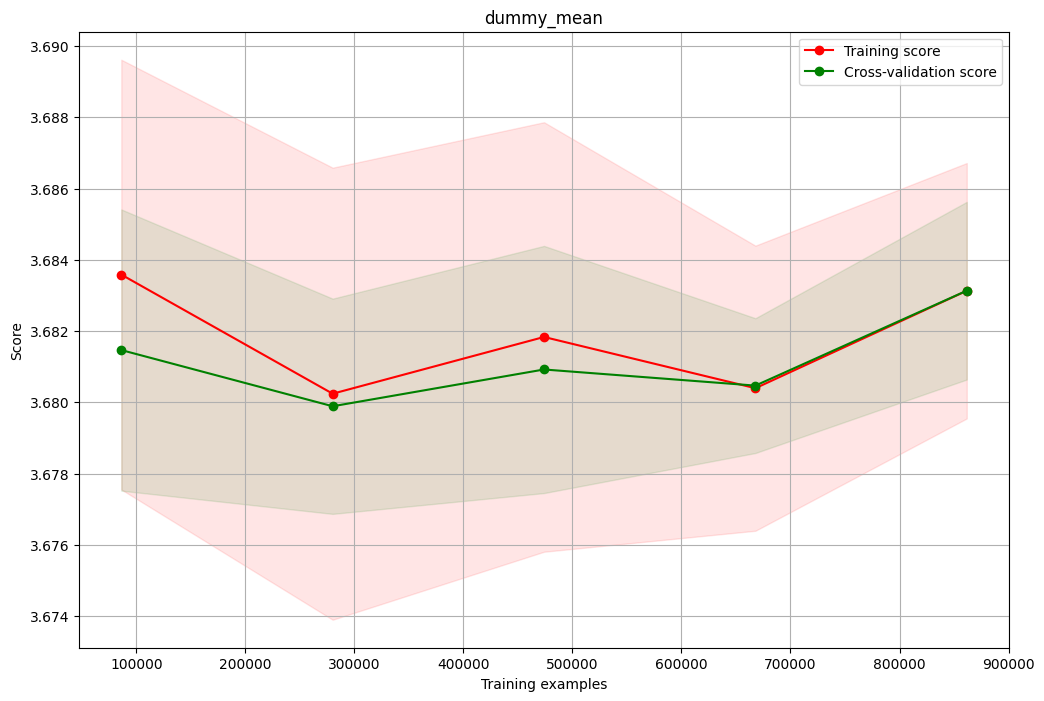

[dummy_median]: 2.3484952093924414 +/-0.004658535118524705


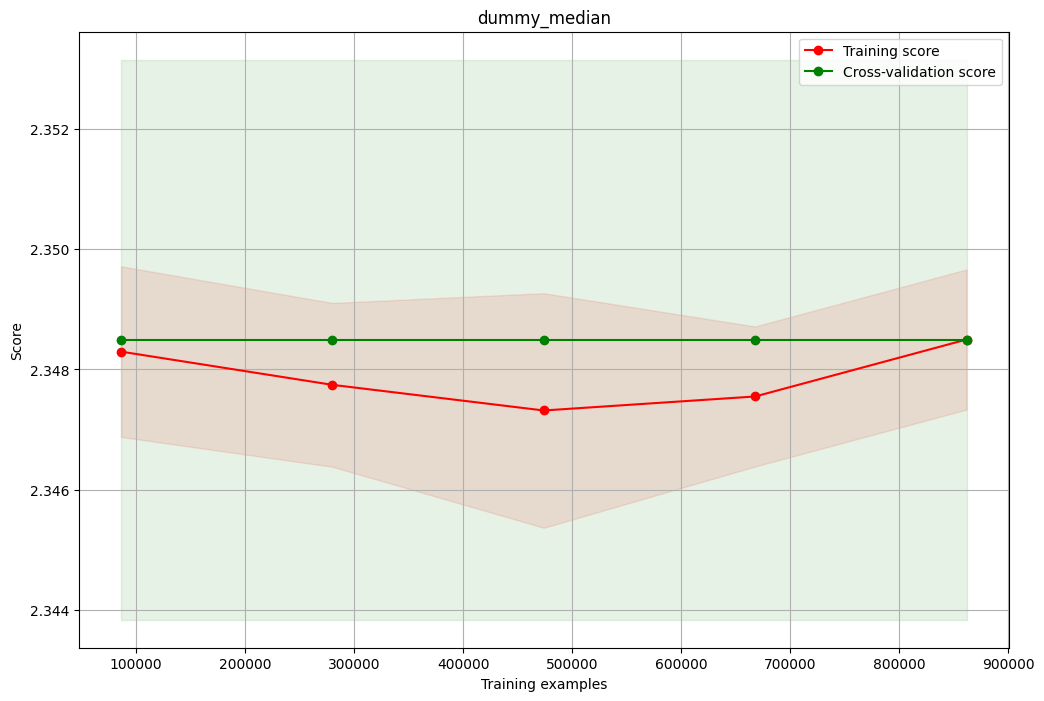

[xgb_initial]: 2.641025649402719 +/-0.006767660761945188


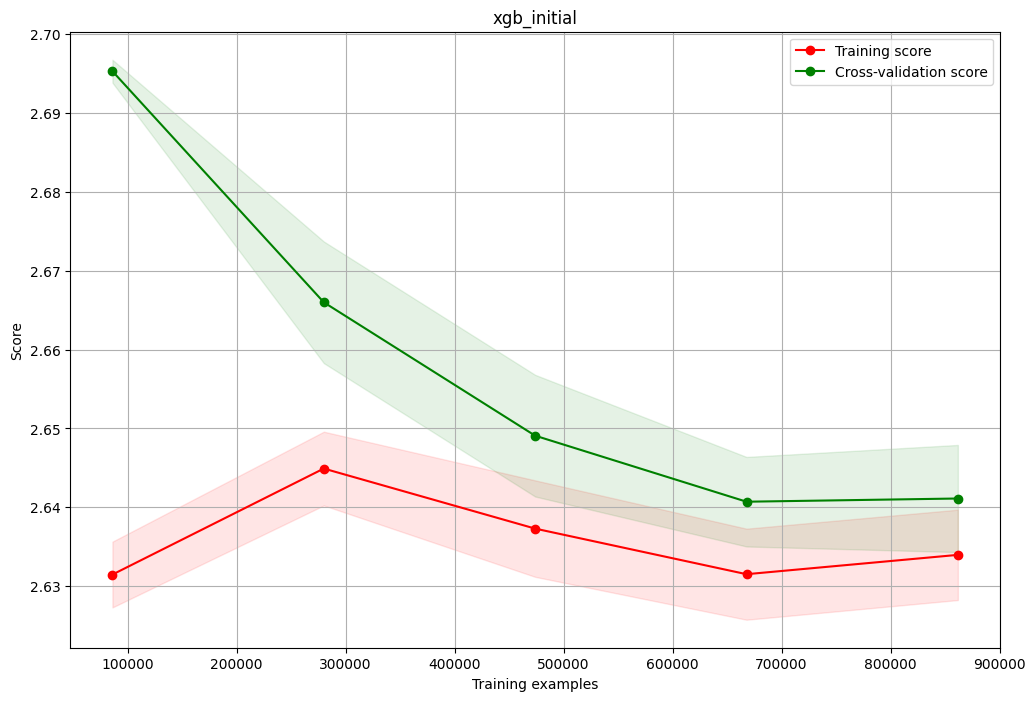

In [29]:
run(train, plot_lc=True, folds=5, ylim=None, target_log=False)

### run() z log

[dummy_mean]: 1.868953721016829 +/-0.0046274558289396105


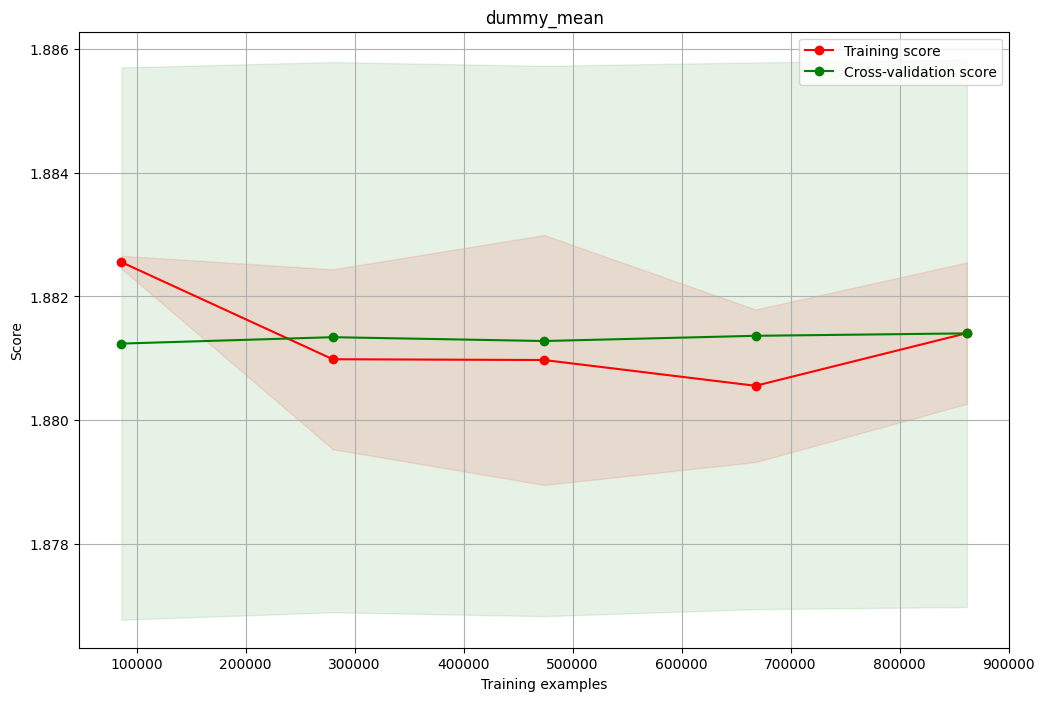

[dummy_median]: 2.3484952093924414 +/-0.004658535118524705


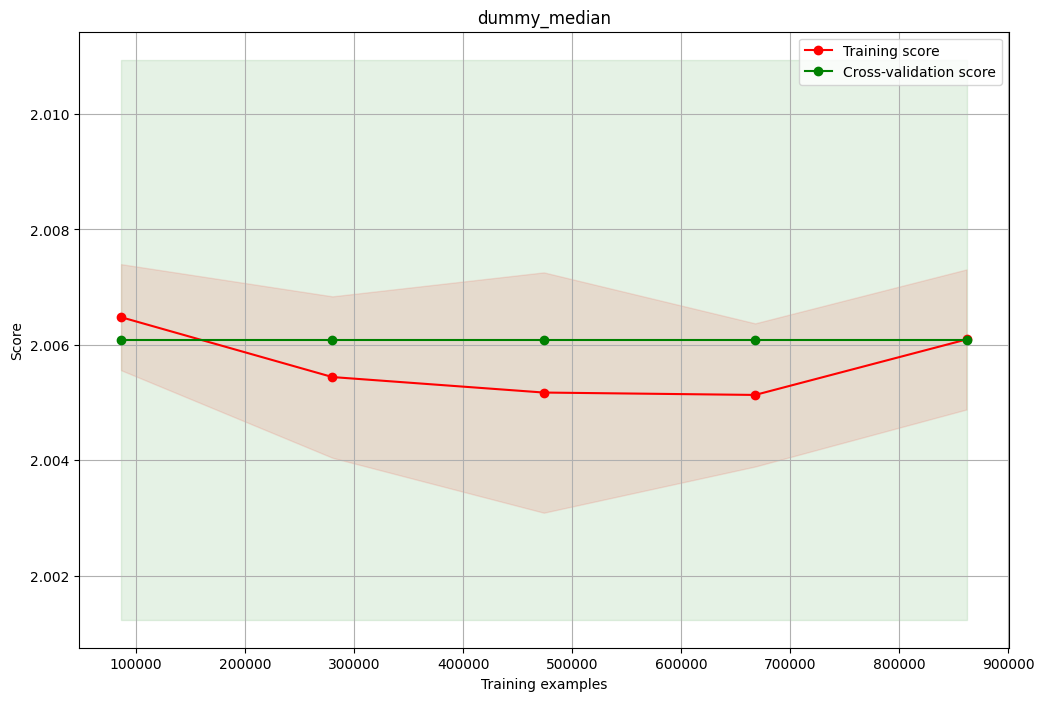

[xgb_initial]: 1.5952884247903867 +/-0.0030329615726165543


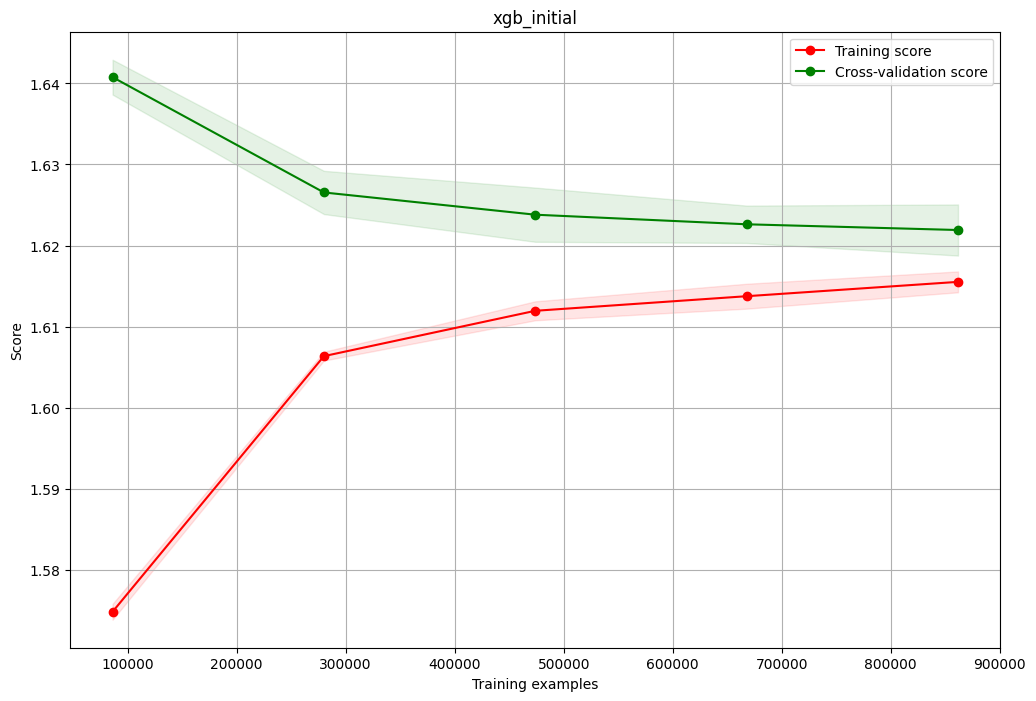

In [30]:
run(train, plot_lc=True, folds=5, ylim=None, target_log=True)

### plot_learning_curve bez log

<module 'matplotlib.pyplot' from '/home/jarek/.virtualenvs/sklearn_venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

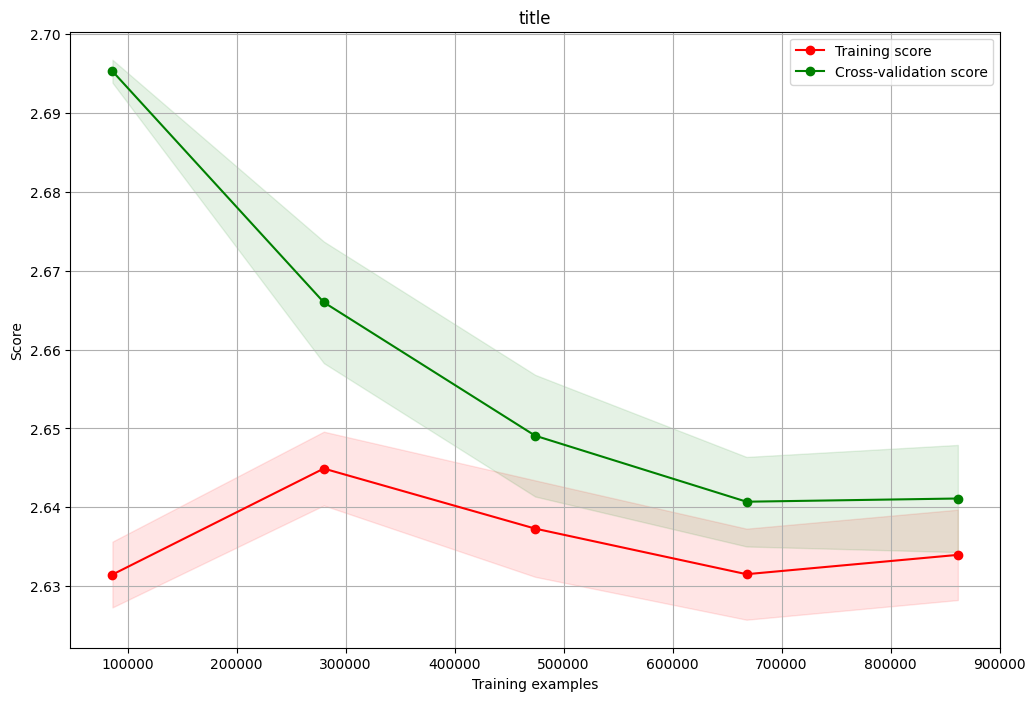

In [31]:
plot_learning_curve(model, "title", X, y, ylim=None, cv=5, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), target_log=False)

### plot_learning_curve z log

<module 'matplotlib.pyplot' from '/home/jarek/.virtualenvs/sklearn_venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

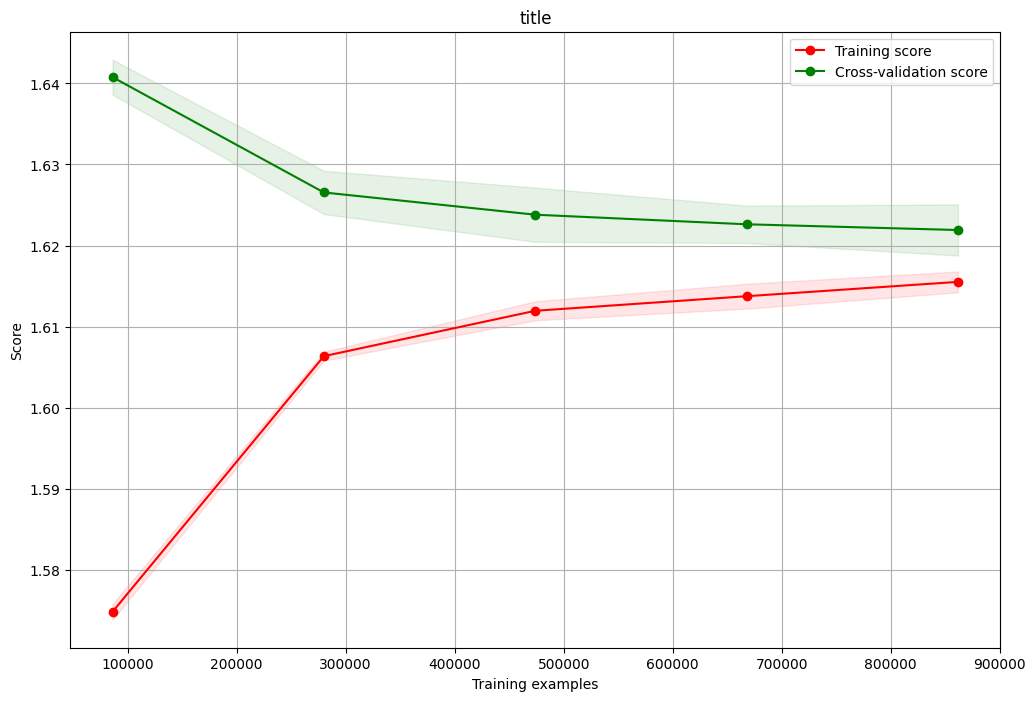

In [32]:
plot_learning_curve(model, "title", X, y, ylim=None, cv=5, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), target_log=True)

In [63]:
df_train.head()

,year,month,actual_departure_time,day_of_month,day_of_week,scheduled_departure_time,actual_arrival_time,scheduled_arrival_time,air_time,arrival_delay,depature_delay,carrier_id,flight_number,tail_number,actual_elapsed_time,scheduled_elapsed_time,origin,destination,distance,is_cancelled,cancellation_code,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,is_diverted,target_delay,origin_cat,destination_cat
0,0,1,943.0,17,2,947.0,1028.0,1037.0,33.0,-9.0,-4.0,13,4780,3022,45.0,50.0,MLI,ORD,139,False,0,0.0,0.0,0.0,0.0,0.0,False,0.0,0,0
1,2,6,905.0,26,4,822.0,1026.0,932.0,117.0,54.0,43.0,7,246,1993,141.0,130.0,SAT,DEN,794,False,0,43.0,0.0,11.0,0.0,0.0,False,54.0,1,1
2,1,12,1255.0,28,5,1255.0,1342.0,1344.0,25.0,-2.0,0.0,13,4867,4955,47.0,49.0,LAX,SBA,89,False,0,0.0,0.0,0.0,0.0,0.0,False,0.0,2,2
3,1,7,2028.0,2,1,1855.0,2136.0,1945.0,33.0,111.0,93.0,15,1505,3734,68.0,50.0,DFW,AUS,190,False,0,0.0,17.0,18.0,0.0,76.0,False,111.0,3,3
4,2,1,1358.0,7,1,1355.0,1437.0,1455.0,85.0,-18.0,3.0,1,5541,5727,99.0,120.0,SLC,LAX,590,False,0,NaN,NaN,NaN,NaN,NaN,False,0.0,4,4


In [101]:
df_train[ df_train['is_cancelled'] == True ]

,year,month,actual_departure_time,day_of_month,day_of_week,scheduled_departure_time,actual_arrival_time,scheduled_arrival_time,air_time,arrival_delay,depature_delay,carrier_id,flight_number,tail_number,actual_elapsed_time,scheduled_elapsed_time,origin,destination,distance,is_cancelled,cancellation_code,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,is_diverted,target_delay,origin_cat,destination_cat
45,0,6,NaN,10,6,2200.0,NaN,2302.0,NaN,NaN,NaN,2,2726,901,NaN,62.0,IAD,PHL,134,True,1,0.0,0.0,0.0,0.0,0.0,False,4320.0,31,30
130,2,7,NaN,27,7,1630.0,NaN,1745.0,NaN,NaN,NaN,13,6657,-1,NaN,75.0,LGA,BOS,185,True,3,NaN,NaN,NaN,NaN,NaN,False,4320.0,53,11
131,2,8,NaN,4,1,1035.0,NaN,1359.0,NaN,NaN,NaN,15,6755,-1,NaN,144.0,DEN,ORD,888,True,1,NaN,NaN,NaN,NaN,NaN,False,4320.0,15,0
156,1,12,NaN,23,7,1700.0,NaN,1830.0,NaN,NaN,NaN,20,7237,10,NaN,90.0,MSP,BIS,386,True,3,0.0,0.0,0.0,0.0,0.0,False,4320.0,61,68
160,0,11,NaN,9,4,805.0,NaN,1135.0,NaN,NaN,NaN,15,3,10,NaN,150.0,DFW,RDU,1062,True,1,0.0,0.0,0.0,0.0,0.0,False,4320.0,3,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1076775,0,9,NaN,15,5,1740.0,NaN,2145.0,NaN,NaN,NaN,15,2068,10,NaN,245.0,SJU,EWR,1608,True,1,0.0,0.0,0.0,0.0,0.0,False,4320.0,124,55
1076800,0,7,NaN,3,1,640.0,NaN,900.0,NaN,NaN,NaN,1,963,10,NaN,80.0,MDW,PIT,402,True,1,0.0,0.0,0.0,0.0,0.0,False,4320.0,24,66
1076825,2,3,NaN,21,5,1848.0,NaN,1859.0,NaN,NaN,NaN,2,3081,861,NaN,71.0,MBS,ORD,222,True,3,NaN,NaN,NaN,NaN,NaN,False,4320.0,180,0
1076833,2,1,NaN,31,4,1020.0,NaN,1135.0,NaN,NaN,NaN,13,4620,-1,NaN,75.0,XNA,DFW,281,True,1,NaN,NaN,NaN,NaN,NaN,False,4320.0,155,22


In [103]:
4320 / 60 /24

3.0

In [33]:
train.head()

,year,month,day_of_month,day_of_week,scheduled_departure_time,scheduled_arrival_time,carrier_id,flight_number,tail_number,scheduled_elapsed_time,distance,origin_cat,destination_cat,target_delay
0,0,1,17,2,947.0,1037.0,13,4780,3022,50.0,139,0,0,0.0
1,2,6,26,4,822.0,932.0,7,246,1993,130.0,794,1,1,54.0
2,1,12,28,5,1255.0,1344.0,13,4867,4955,49.0,89,2,2,0.0
3,1,7,2,1,1855.0,1945.0,15,1505,3734,50.0,190,3,3,111.0
4,2,1,7,1,1355.0,1455.0,1,5541,5727,120.0,590,4,4,0.0


In [23]:
1037.0 - 947.0

90.0

In [95]:
import arrow

((arrow.get('1037', 'HHmm')) - (arrow.get('0947', 'HHmm'))).seconds / 60

50.0

In [96]:
((arrow.get('1028', 'HHmm')) - (arrow.get('0943', 'HHmm'))).seconds / 60

45.0

In [108]:
from datetime import date
import holidays
  
# Select country
usa_holidays = holidays.USA()
  

for ptr in holidays.USA(years = 2018).items():
    print(ptr[0].weekday(), ptr[1])

0 New Year's Day
0 Martin Luther King Jr. Day
0 Washington's Birthday
0 Memorial Day
2 Independence Day
0 Labor Day
0 Columbus Day
6 Veterans Day
0 Veterans Day (Observed)
3 Thanksgiving
1 Christmas Day


In [107]:
for ptr in holidays.USA(years = 2019).items():
    print(ptr[0].weekday(), ptr[1])

1 New Year's Day
0 Martin Luther King Jr. Day
0 Washington's Birthday
0 Memorial Day
3 Independence Day
0 Labor Day
0 Columbus Day
0 Veterans Day
3 Thanksgiving
2 Christmas Day


In [64]:
# !pip install airportsdata

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 2.3 MB/s eta 0:00:002.2 MB/s eta 0:00:01


In [71]:
import airportsdata
airports = airportsdata.load('IATA')  # key is IATA code
print(airports['MLI'])

{'icao': 'KMLI', 'iata': 'MLI', 'name': 'Quad City International Airport', 'city': 'Moline', 'subd': 'Illinois', 'country': 'US', 'elevation': 590.0, 'lat': 41.4485015869, 'lon': -90.5074996948, 'tz': 'America/Chicago'}


In [104]:
# pomysły
# - lotniska z tego samego stanu, elevation, lat & long
# - prędkość: distance / scheduled_elapsed_time
# - najbardziej obciążone lotniska, groupby dla lotnisko i liczba lotów
# - czy luty, czy grudzień - prawdopodobieństwo spóźnienia

In [115]:
df_train['is_cancelled'].mean()

0.019421342587692667

In [127]:
df_train.groupby('month')['is_cancelled'].agg('mean') * 100

month
1     2.333337
2     3.456002
3     2.107693
4     1.598500
5     1.124780
6     2.099166
7     1.868812
8     1.604698
9     1.625837
10    1.216559
11    1.208498
12    3.193875
Name: is_cancelled, dtype: float64

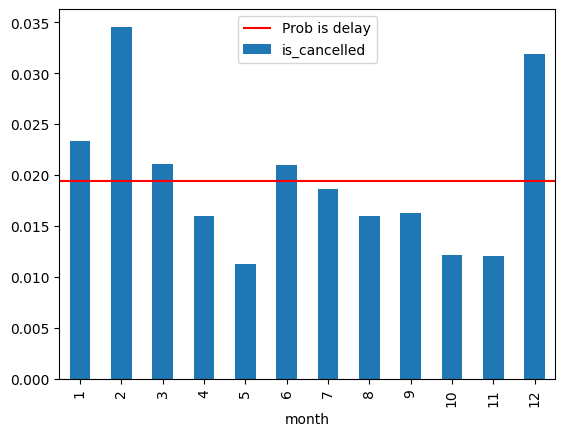

In [124]:
df_train.groupby('month')['is_cancelled'].agg('mean').plot(kind='bar')
plt.hlines(y=np.mean(df_train['is_cancelled']), xmin=-1, xmax=12, colors='red', label="Prob is delay")
plt.legend();

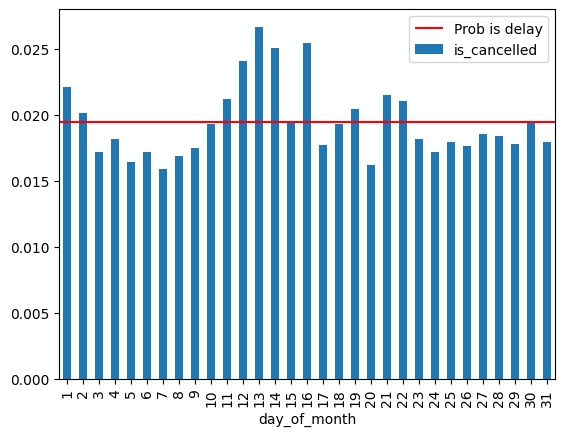

In [131]:
df_train.groupby('day_of_month')['is_cancelled'].agg('mean').plot(kind='bar')
plt.hlines(y=np.mean(df_train['is_cancelled']), xmin=-1, xmax=31, colors='red', label="Prob is delay")
plt.legend();

In [132]:
df_train.groupby('day_of_month')['is_cancelled'].agg('mean') > 0.02

day_of_month
1      True
2      True
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11     True
12     True
13     True
14     True
15    False
16     True
17    False
18    False
19     True
20    False
21     True
22     True
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
Name: is_cancelled, dtype: bool

In [139]:
df_train[[ 'distance', 'is_cancelled']].groupby('is_cancelled').agg(['mean', 'median', 'min', 'max'])

distance                 
                    mean median min   max
is_cancelled                             
False         726.358518  576.0  11  4962
True          565.179024  441.0  21  4502

In [25]:
df_tail_delay =  df_filtered[["tail_number", "target_delay"]].groupby("tail_number").agg(
    mean_tail_delay=("target_delay", "mean"),
    median_tail_delay=("target_delay", "median"),
    count_tail_delay=("target_delay", "count"),
    count_zeros_tail_delay=("target_delay", lambda vals: len([x for x in vals if x == 0]) ),
    prob_zeros_tail_delay=("target_delay", lambda vals: np.mean([x == 0 for x in vals]) ),
).reset_index()

if "mean_tail_delay" not in df_train:
    df_filtered = pd.merge(df_filtered, df_tail_delay, on="tail_number", how="left")
    
if "mean_tail_delay" not in df_test:
    df_test = pd.merge(df_test, df_tail_delay, on="tail_number", how="left")

In [31]:
new_feats = [n for n in df_filtered.columns if "_tail_delay" in n]
feats = feats + new_feats

In [32]:
check_model(df=df_filtered, feats=feats, model=model)

NameError: name 'check_model' is not defined

In [41]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'matthews_corrcoef', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_s